In [138]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [150]:
TIME_RESOLUTION = 0.72  # Time resolution, in seconds
HCP_DIR = "./hcp_task"

DATA_LENGTH = 176
DURATION = 18.0
OFFSET = 5

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')
regions = np.load(f"{HCP_DIR}/regions.npy").T

In [201]:
# Helper functions.
def load_timeseries(file_path, remove_mean = True):
    ts = np.load(file_path)
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)

    return_dict = {}
    for i in range(len(regions[0])):
        return_dict[regions[0][i]] = ts[i]
    
    return return_dict

def load_evs(ev_directory):
    neut = np.loadtxt(f"{ev_directory}/neut.txt", ndmin=2, unpack=True)
    neut_onset = neut[0]
    neut_duration = neut[1]
    assert np.all(neut_duration == DURATION)

    fear = np.loadtxt(f"{ev_directory}/fear.txt", ndmin=2, unpack=True)
    fear_onset = fear[0]
    fear_duration = fear[1]
    assert np.all(fear_duration == DURATION)

    combined = [("Neut", onset) for onset in neut_onset] + [("Fear", onset) for onset in fear_onset]
    _sorted = sorted(combined, key=lambda x: x[1])

    return_array = []
    for condition, onset in _sorted:
        
        start_frame = np.floor(onset / TIME_RESOLUTION).astype(int)
        end_frame = start_frame + np.ceil(DURATION / TIME_RESOLUTION).astype(int)

        start_frame = start_frame + OFFSET
        end_frame = end_frame + OFFSET

        if (end_frame >= DATA_LENGTH):
            end_frame = DATA_LENGTH

        return_array.append({
            "Condition": condition,
            "Onset": onset,
            "Duration": DURATION,
            "Frames": (start_frame, end_frame)
        })

    return return_array


In [202]:
# Create full data structure. 
manifest = {}
for subject_id in subjects:
     
    if subject_id not in manifest:
        manifest[subject_id] = []
            
    for trial_index, trial in enumerate(["LR", "RL"]):
        data_path = f"{HCP_DIR}/subjects/{subject_id}/EMOTION/tfMRI_EMOTION_{trial}/data.npy"
        ev_path = f"{HCP_DIR}/subjects/{subject_id}/EMOTION/tfMRI_EMOTION_{trial}/EVs"

        time_series = load_timeseries(data_path)
        condition_data = load_evs(ev_path)

        manifest[subject_id].append({
            "region_data": time_series,
            "condition_spans": condition_data
        })

Subject 0: 100307
	Trial: 1
		Block 1: Neut condition starts at 10.982 and runs for 18.0 containing frames: (15, 40)
		Block 2: Fear condition starts at 32.053 and runs for 18.0 containing frames: (44, 69)
		Block 3: Neut condition starts at 53.125 and runs for 18.0 containing frames: (73, 98)
		Block 4: Fear condition starts at 74.196 and runs for 18.0 containing frames: (103, 128)
		Block 5: Neut condition starts at 95.267 and runs for 18.0 containing frames: (132, 157)
		Block 6: Fear condition starts at 116.338 and runs for 18.0 containing frames: (161, 176)


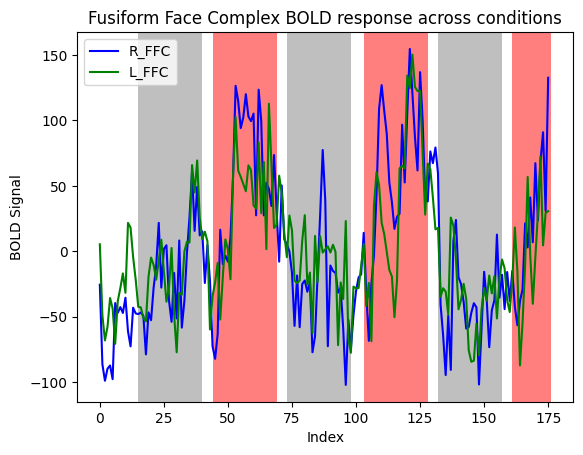

In [217]:
for subject_index, subject_id in enumerate(subjects):
    print(f"Subject {subject_index}: {subject_id}")
    
    for trial_index, trial in enumerate(manifest[subject_id]):
        print(f"\tTrial: {trial_index + 1}")

        plt.plot(trial["region_data"]["R_FFC"], color="blue", label="R_FFC")
        plt.plot(trial["region_data"]["L_FFC"], color="green", label="L_FFC")

        for block_index, conditon_dict in enumerate(trial["condition_spans"]): 
            print(f"\t\tBlock {block_index + 1}: {conditon_dict['Condition']} condition starts at {conditon_dict['Onset']} and runs for {conditon_dict['Duration']} containing frames: {conditon_dict['Frames']}")

            start_index = conditon_dict['Frames'][0]
            end_index = conditon_dict['Frames'][1]

            if conditon_dict['Condition'] == "Neut":
                plt.axvspan(start_index, end_index, facecolor="gray", alpha=0.5)

            if conditon_dict['Condition'] == "Fear":
                plt.axvspan(start_index, end_index, facecolor="red", alpha=0.5)

        plt.title('Fusiform Face Complex BOLD response across conditions')
        plt.xlabel('Index')
        plt.ylabel('BOLD Signal')

        plt.legend()
        plt.show()

        break
    break